# Comparison of Standard IF to Cyclic IF

**Question:** How does the signal-to-background ratio and staining specificity compare in standard IF vs. cyclic IF?

**Samples:** 
- Tissue ID 44290: HER2+/ER+ breast cancer. Section 112 stained with a 5 round cyclic IF protocol, sections 113 to 116 stained with the same antibodies in a standard IF protocol.
- Tissue ID 44294: Adjacent normal breast from the patient above. Section 116 is cyclic, section 117 to 120 are standard IF.

**Method**: For each stain, pixel intensity was manually thresholded to separate the positive pixels from the negative, in Extended data figure 2 notebook. We also automatically estimated dynamic range using the 5th and 98th percentile of single cell intensity in the tissue.

In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import os
from scipy.stats.stats import pearsonr
import itertools
from scipy import stats
import seaborn as sns
matplotlib.rcParams.update({'font.size': 16})

## Notes 44290 (HER2+ Breast Cancer)
The single stains have much worse edge effect.
Define 2 ROIs with similar composition, avoiding edge regions. (x,y,w,h)

44290-112: (cyclic)
- (3200,5500,1500,1500) ROI1 large tumor nest upper left
- (5000,8800,1500,1800) ROI2 large tumor nests lower right
- only two regions in 44290 are suitable, due to autofluorescent regions that are different between single and cyclic stains. 

44290-113 (single PCNA, HER2, ER, CD45)
- (800,3050,1500,1500)
- (2650,6400,1500,1800)

44290-114 (single pHH3, CK14, CD44, CK5)
- (900,2900,1500,1500)
- (2650,6250,1500,1800)

44290-115 (single Vim, CK7, PD1, Lamin A/C)
- (900,2950,1500,1500)
- (2850,6200,1500,1800)

44290-116 (single aSMA, CD68, Ki67, Ecad)
- (850,3000,1500,1500)
- (2650,6250,1500,1800)

## Notes 44294 (Normal Breast)
The single stains on normal tissue don't have such bad edge effect, although they do have to autoflourescence in the DAPI negative areas (i.e. middle of the duct). We can use the whole segmented images, as segmentation based on DAPI will ignore most of the worst autofluorescence areas.

44294-116 was not cropped before segmentation, while the other tissues were.
Therefore, I will use an ROI to make 44294-116 the same size as the other tissues.

44294-116:
- (7200,3580,12725,12365) (scene001)

## Load Data

In [2]:
#set location of files
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir = os.getcwd()

In [3]:
#load threshold, SNR data
df_t = pd.read_csv(f'{codedir}/Metadata/44290/SNR_single_vs_cyclic.csv',index_col=0)

#load metadata from feature extraction
df_m = pd.read_csv(f'{codedir}/Metadata/44290/metadata_single_vs_cyclic.csv',index_col=0)

In [4]:
#import dataframes with mean intensity/centroid from segmentation and feature extraction
#df_mi =pd.read_csv(f'{codedir}/BigData/features_singlevscyclic.csv',index_col=0)
#df_mi['slide'] = [item.split('_')[0] for item in df_mi.index]
#for s_slide in sorted(set(df_mi.slide)):
#    df_mi[df_mi.slide==s_slide].to_csv(f'{codedir}/Data/features_{s_slide}_singlevscyclic.csv')

In [5]:
#import dataframes with mean intensity/centroid from segmentation and feature extraction
ls_slide =  ['44290-112', '44290-113', '44290-114', '44290-115', '44290-116', 
             '44294-116', '44294-117', '44294-118', '44294-119', '44294-120']
df_mi = pd.DataFrame()
for s_slide in ls_slide:
    df_mi = df_mi.append(pd.read_csv(f'{codedir}/Data/features_{s_slide}_singlevscyclic.csv',index_col=0))

In [6]:
#add the slide/scene information 
df_mi['scene'] = [item.split('_')[1] for item in df_mi.index]
df_mi['slide'] = [item.split('_')[0] for item in df_mi.index]

df_t['experiment'] = [item.split('_')[0] for item in df_t.condition]
df_t['experimenttype'] = [item.split('_')[2] for item in df_t.condition]
df_t = df_t.sort_values(['color','rounds'])

#calculate actual signal (ie measure signal minus background)
df_t['meanpos'] = df_t.meanpos - df_t.meanneg

In [7]:
#cropping used for images (different from the features)
#new 20191209
d_crop_image = {'44290-112':(5000,8800,1300,1800),
 '44290-113':(5886,8111,1300,1800),
 '44290-114':(5010,9242,1300,1800),
 '44290-115':(5975,10490,1300,1800),
 '44290-116':(6336,9174,1300,1800),
 '44294-116':(9547,5459,1300,1800),
 '44294-117':(12180,6092, 1300,1800),
 '44294-118':(10901, 6582, 1300,1800),
 '44294-119':(9853,5557, 1300,1800),
 '44294-120':(10250,5510, 1300,1800),
 }
d_crop_feat = {'44290-112':(5000,8800,1300,1800),
 '44290-113':(2650,6400,1300,1800),
 '44290-114':(2650,6250,1300,1800),
 '44290-115':(2850,6200,1300,1800),
 '44290-116':(2650,6250,1300,1800),
 '44294-116':(7200,3580,12725,12365),
 '44294-117':(0,0,0,0),
 '44294-118':(0,0,0,0),
 '44294-119':(0,0,0,0),
 '44294-120':(0,0,0,0),
 }

In [8]:
#define rois (see notes above about ROIs to exclude autofluorescence)
df_rois = pd.DataFrame()
for s_tissue, t_coord in d_crop_feat.items():
    #print(s_tissue)
    if t_coord == (0,0,0,0):
        df_scene = df_mi[df_mi.slide==s_tissue]
    else:
        x_min = t_coord[0]
        x_max = t_coord[0] + t_coord[2]
        y_min = t_coord[1]
        y_max = t_coord[1] + t_coord[3]
        df_scene = df_mi[df_mi.slide==s_tissue]
        df_scene = df_scene.loc[(x_max > df_scene.DAPI_X) & (df_scene.DAPI_X > x_min)]
        df_scene = df_scene.loc[(y_max > df_scene.DAPI_Y) & (df_scene.DAPI_Y > y_min)]
    df_rois = df_rois.append(df_scene)

# Percent Positive

Thresholds were set on the images, using the pattern of staining to set an intensity value above which pixels were considered positive for a stain.

Here, the same theresholds are applied to the single cell mean intensity values. If a cell has a mean intensity above the pixel threshold, it is considered positive. Percent of positive cells over all segmented cells is calculated for each marker.

In [9]:
#calculate positive cells based on thresholding the mean intensity dataframe

#empty dataframe
df_pos = pd.DataFrame()

#for each sample
for s_index in df_t.index:
    s_exp = df_t.loc[s_index,'experiment']
    s_tissue = df_t.loc[s_index,'scene']
    s_marker = df_t.loc[s_index,'marker']
    s_type = df_t.loc[s_index,'experimenttype']
    df_m_slide = df_m[(df_m.slide==s_tissue) & (df_m.marker == s_marker)]
    if len(df_m_slide) !=1:
        print(df_m_slide)
    #when the features were extracted we had some exposure normalization ... need to undo
    i_thresh = df_t.loc[s_index,'minimum']/(df_m_slide.loc[:,'refexp']/df_m_slide.loc[:,'exposure'])
    s_marker_loc = df_rois.columns[pd.Series([item.split('_')[0]==s_marker for item in df_rois.columns])][0]
    df_pos.loc[s_marker,f'{s_exp}_{s_type}'] = (df_rois[df_rois.slide==s_tissue].loc[:,s_marker_loc] > i_thresh[0]).sum()
   

In [10]:
#generate dataframe for plotting
#tumor
df_percent = pd.DataFrame()
df_percent['tumor'] = (df_pos.dropna(axis=0).single_tumor/df_pos.dropna(axis=0).cyclic_tumor).fillna(1)
#normal
df_percent['normal'] = (df_pos.dropna(axis=0).single_normal/df_pos.dropna(axis=0).cyclic_normal).fillna(1)



df_tum = pd.DataFrame(df_percent.unstack().tumor, columns=['value'])
df_norm = pd.DataFrame(df_percent.unstack().normal, columns=['value'])
df_tum['type'] = 'tumor'
df_norm['type'] = 'normal'
df_tum['marker'] = df_tum.index.tolist()
df_norm['marker'] = df_norm.index.tolist()
df_longer = df_tum.append(df_norm)
df_longer = df_longer.drop('pH3')

ls_order = df_tum.index

#stats
print(df_longer.groupby('marker').mean().mean())
print(df_longer.groupby('marker').mean().std())


value    0.963781
dtype: float64
value    0.188409
dtype: float64


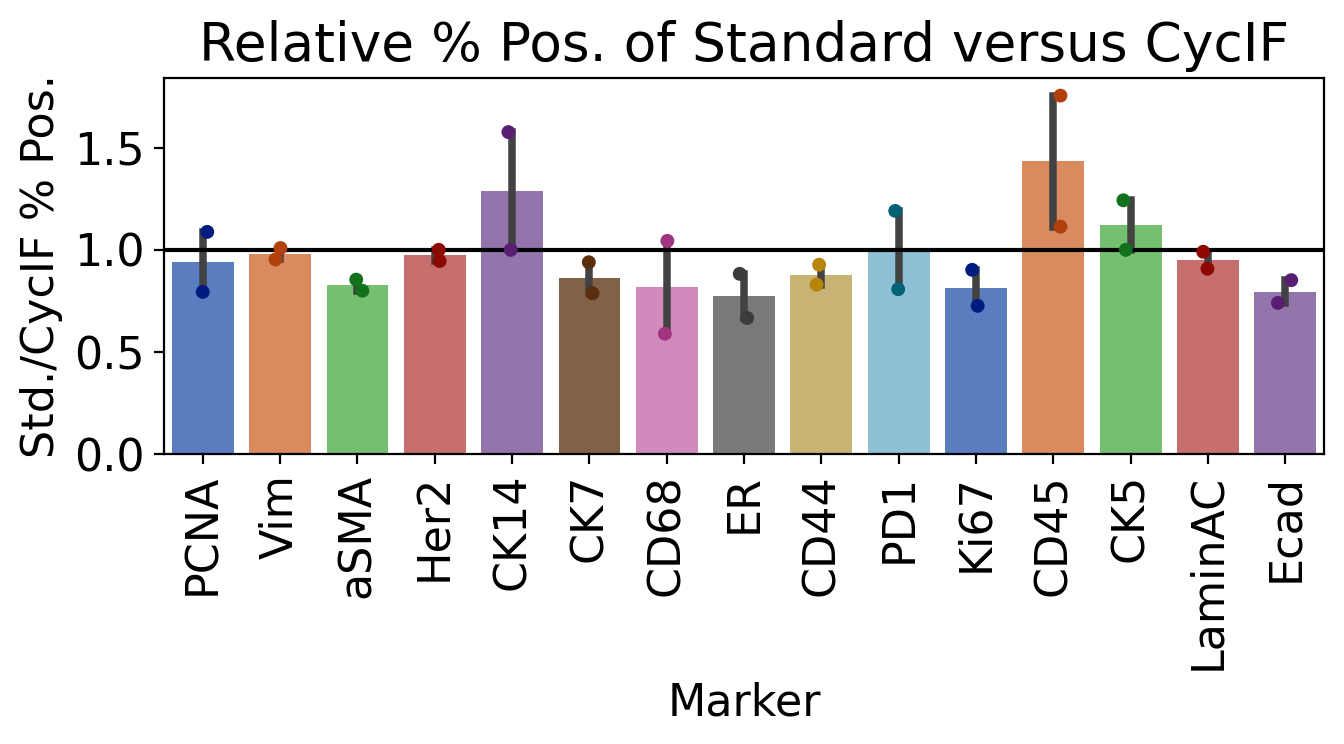

In [11]:
#barplot

s_title = 'Relative % Pos. of Standard versus CycIF'
s_ylabel = "Std./CycIF % Pos."
s_figname =f'{codedir}/Figures/44290/Percent_Positive_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted',ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)

ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)


# mean intensity

The mean intensity of pixels above the threshold

In [12]:
#generate dataframe for plotting
df_percent = pd.DataFrame()
se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='tumor')]).groupby('marker').meanpos.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='tumor')]).groupby('marker').meanpos.mean()
df_percent['tumor'] = (se_single/se_tumor).fillna(1)

se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='normal')]).groupby('marker').meanpos.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='normal')]).groupby('marker').meanpos.mean()
df_percent['normal'] = (se_single/se_tumor).fillna(1)

df_tum = pd.DataFrame(df_percent.unstack().tumor, columns=['value'])
df_norm = pd.DataFrame(df_percent.unstack().normal, columns=['value'])
df_tum['type'] = 'tumor'
df_norm['type'] = 'normal'
df_tum['marker'] = df_tum.index.tolist()
df_norm['marker'] = df_norm.index.tolist()
df_tum = df_tum.reindex(ls_order)
df_norm = df_norm.reindex(ls_order)
df_longer = df_tum.append(df_norm)
df_longer = df_longer.drop('pH3')

#stats
print(df_longer.groupby('marker').mean().mean())
print(df_longer.groupby('marker').mean().std())


value    1.198536
dtype: float64
value    0.383773
dtype: float64


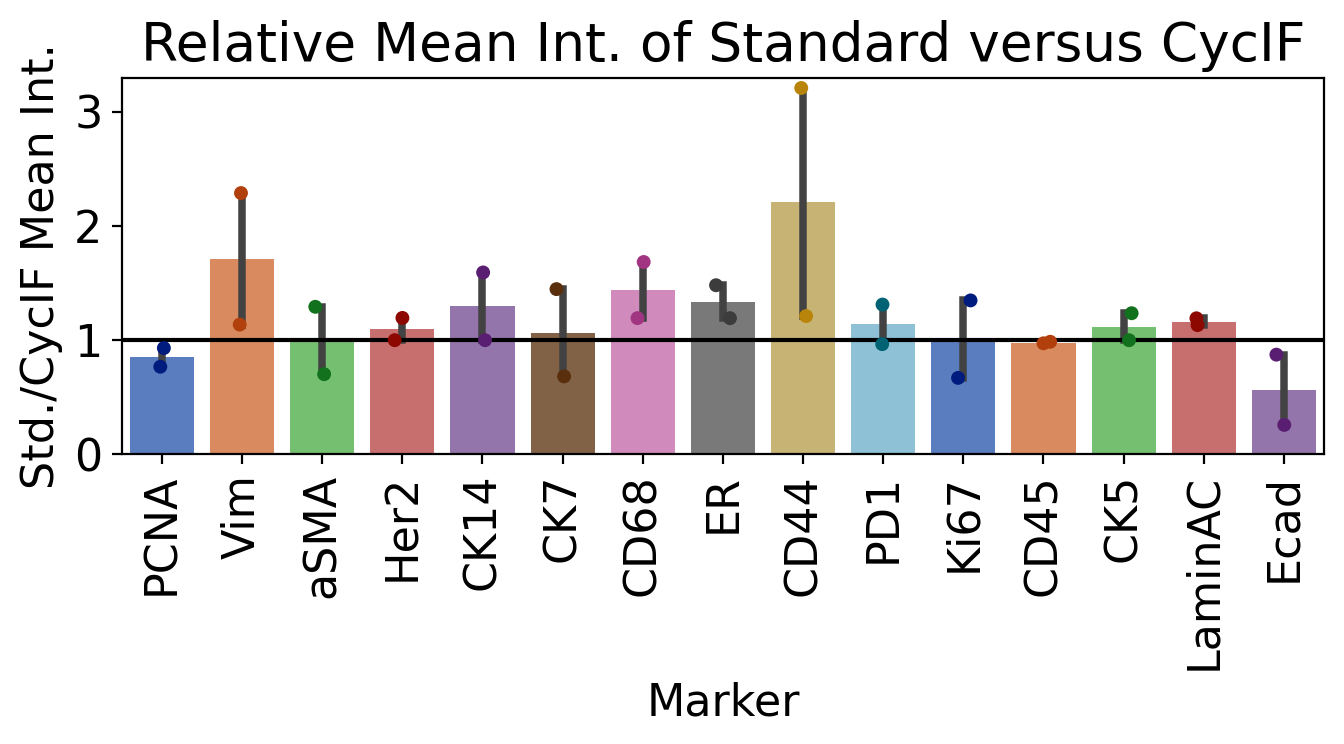

In [13]:
#barplot

s_title = 'Relative Mean Int. of Standard versus CycIF'
s_ylabel = "Std./CycIF Mean Int."
s_figname =f'{codedir}/Figures/44290/Mean_Int_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted', ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,3.3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)


# background

the mean intensity of pixels below the threshold

In [14]:
#generate dataframe for plotting
df_percent = pd.DataFrame()
se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='tumor')]).groupby('marker').meanneg.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='tumor')]).groupby('marker').meanneg.mean()
df_percent['tumor'] = (se_single/se_tumor).fillna(1)

se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='normal')]).groupby('marker').meanneg.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='normal')]).groupby('marker').meanneg.mean()
df_percent['normal'] = (se_single/se_tumor).fillna(1)


df_tum = pd.DataFrame(df_percent.unstack().tumor, columns=['value'])
df_norm = pd.DataFrame(df_percent.unstack().normal, columns=['value'])
df_tum['type'] = 'tumor'
df_norm['type'] = 'normal'
df_tum['marker'] = df_tum.index.tolist()
df_norm['marker'] = df_norm.index.tolist()
df_tum = df_tum.reindex(ls_order)
df_norm = df_norm.reindex(ls_order)
df_longer = df_tum.append(df_norm)
df_longer = df_longer.drop('pH3')

#stats
print(df_longer.groupby('marker').mean().mean())
print(df_longer.groupby('marker').mean().std())


value    1.336011
dtype: float64
value    0.505594
dtype: float64


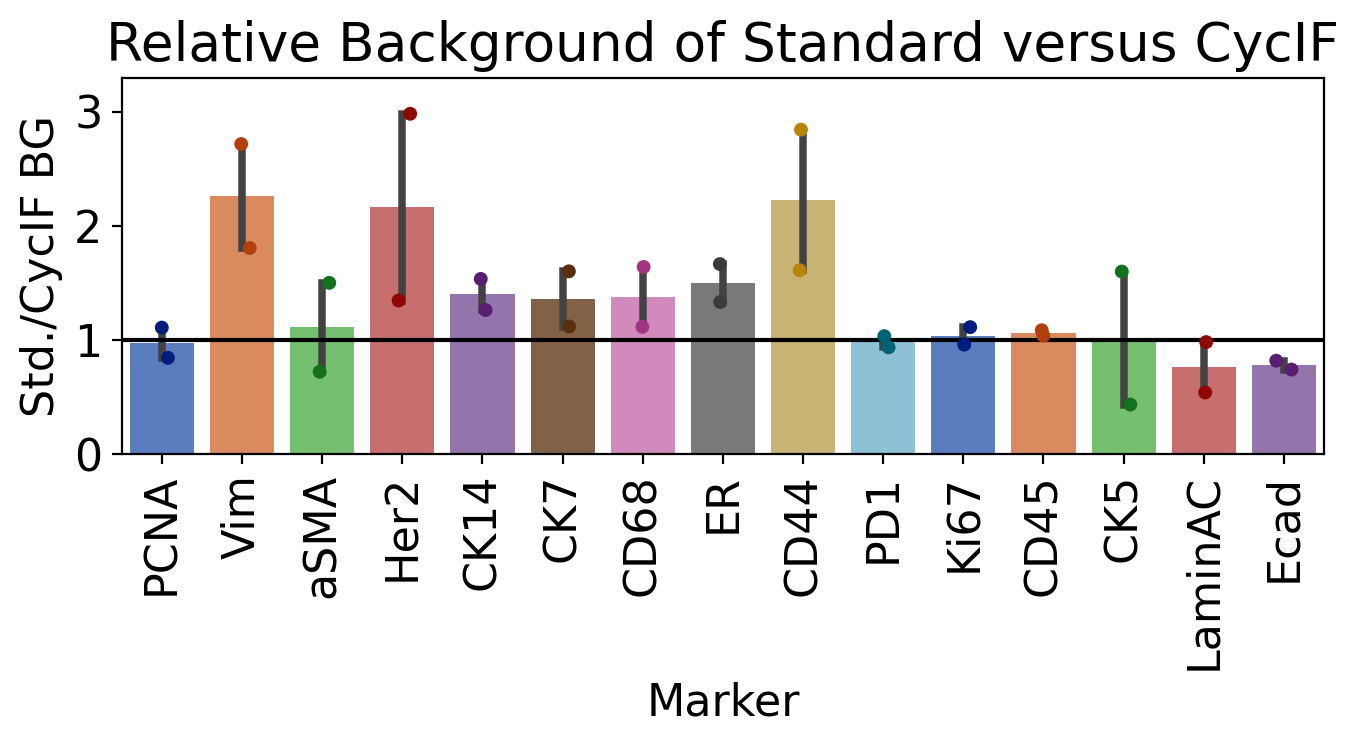

In [15]:
#barplot

s_title = 'Relative Background of Standard versus CycIF'
s_ylabel = "Std./CycIF BG"
s_figname =f'{codedir}/Figures/44290/BG_Int_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted', ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,3.3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)



# SBR

mean intensity above threshold/mean intensity below threshold

In [16]:
#df_t['SNR'] = (df_t.meanpos-df_t.meanneg)/df_t.meanneg already corrected for
df_t['SNR'] = df_t.meanpos/df_t.meanneg
#generate dataframe for plotting
df_percent = pd.DataFrame()
se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='tumor')]).groupby('marker').SNR.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='tumor')]).groupby('marker').SNR.mean()
df_percent['tumor'] = (se_single/se_tumor).fillna(1)

se_single = ((df_t[(df_t.experiment=='single') & (df_t.experimenttype=='normal')]).groupby('marker').SNR.mean())
se_tumor = (df_t[(df_t.experiment=='cyclic') & ~df_t.marker.isin(['CD20','CD8','CD4','CK19'])  & (df_t.experimenttype=='normal')]).groupby('marker').SNR.mean()
df_percent['normal'] = (se_single/se_tumor).fillna(1)

df_tum = pd.DataFrame(df_percent.unstack().tumor, columns=['value'])
df_norm = pd.DataFrame(df_percent.unstack().normal, columns=['value'])
df_tum['type'] = 'tumor'
df_norm['type'] = 'normal'
df_tum['marker'] = df_tum.index.tolist()
df_norm['marker'] = df_norm.index.tolist()
df_tum = df_tum.reindex(ls_order)
df_norm = df_norm.reindex(ls_order)
df_longer = df_tum.append(df_norm)
df_longer = df_longer.drop('pH3')

#stats
print(df_longer.groupby('marker').mean().mean())
print(df_longer.groupby('marker').mean().std())


value    0.960512
dtype: float64
value    0.223502
dtype: float64


In [20]:
#to get SBR of less than 1, must have areas of background that are brighter than the background in stained areas
#(therefore we are subtracting too much) 
#For these markers, the assumption of background adding to the signal of interest may be violated
#df_t[df_t.SNR<1]

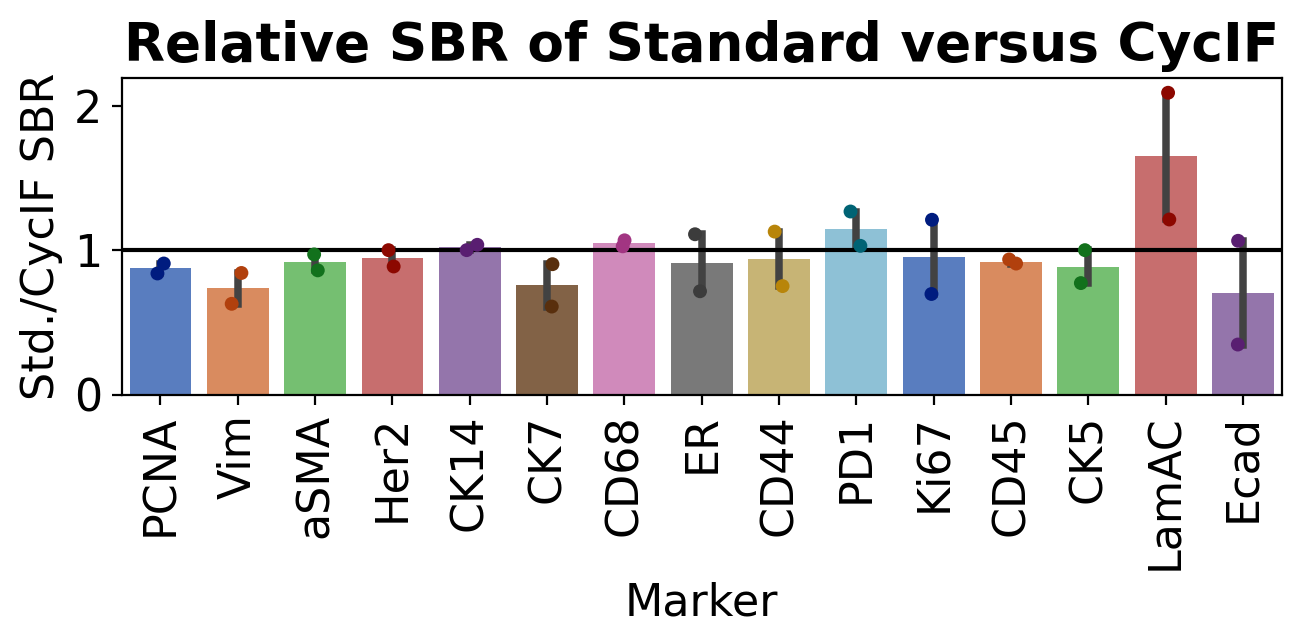

In [37]:
#barplot zoomed in
s_title = 'Relative SBR of Standard versus CycIF'
s_ylabel = "Std./CycIF SBR"
s_figname =f'{codedir}/Figures/44290/SBR_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,3.5),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted', ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
#ax.set_ylim(0,3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
labels[13] = 'LamAC'
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title,fontweight='bold')

plt.tight_layout()
fig.savefig(s_figname)


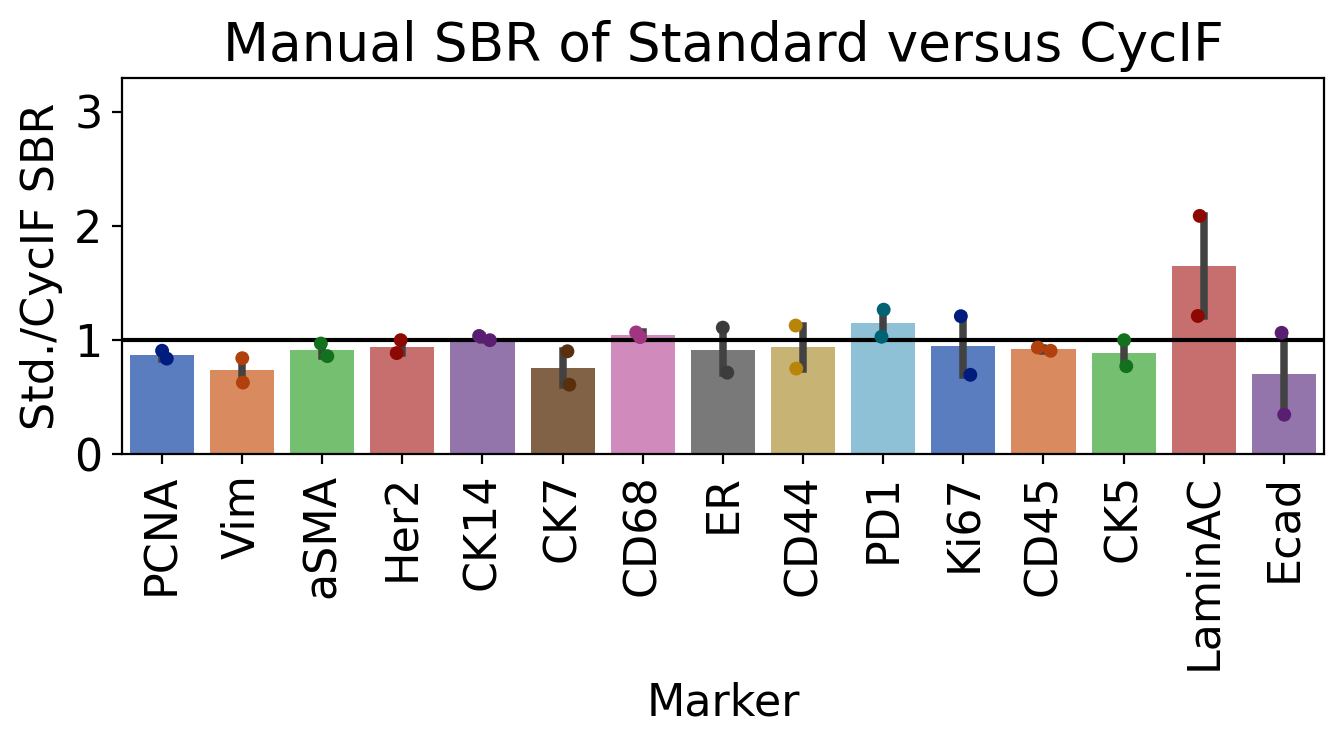

In [22]:
#barplot
s_title = 'Manual SBR of Standard versus CycIF'
s_ylabel = "Std./CycIF SBR"
s_figname =f'{codedir}/Figures/44290/SBR_Ratio_Single-Cyclic_0-3.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_longer, x='marker', y='value', palette = 'muted',ci='sd')
sns.stripplot(data=df_longer, x='marker', y='value', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,3.3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)


# histograms 

Visualize the distribution of single-cell intensity in the standard IF versus the cyclic IF

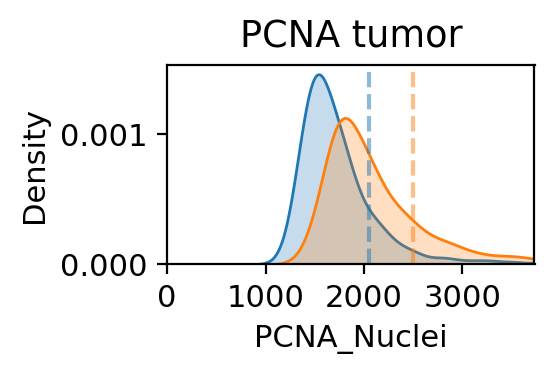

In [20]:
#histograms showing manual threshold
matplotlib.rcParams.update({'font.size': 11})

for s_slide in sorted(df_t[df_t.experiment=='single'].slide.unique()):
    ls_marker = df_t[df_t.slide==s_slide].marker.tolist()
    ls_marker_loc = [df_rois.columns[df_rois.columns.str.contains(item + '_' )][0] for item in ls_marker]
    df_single = df_rois.loc[df_rois.index.str.contains(s_slide),ls_marker_loc]
    s_tissue = df_t[df_t.slide==s_slide].experimenttype[0]
    s_cyclic = df_t[(df_t.experimenttype=='tumor') & (df_t.experiment=='cyclic')].slide[0]
    df_cyclic = df_rois.loc[df_rois.index.str.contains(s_cyclic),ls_marker_loc]
    for idx, s_marker in enumerate(ls_marker_loc):
        se_single = df_single.loc[:,s_marker]
        se_cyclic = df_cyclic.loc[:,s_marker]
        if se_single.isna().sum()==0:
            fig,ax = plt.subplots(1,1,figsize=(3,2),dpi=200)
            i_max = np.quantile(se_single.append(se_cyclic),0.98)
            sns.kdeplot(se_single,shade=True,ax=ax,clip=(0,i_max),label=f"single")
            sns.kdeplot(se_cyclic,shade=True,ax=ax,clip=(0,i_max),label=f"cyclic") 
            #single thresh
            i_high = np.quantile(se_single,.95)
            i_low = np.quantile(se_single,.05)
            i_manual = df_t[(df_t.experimenttype==s_tissue) & (df_t.experiment=='single')& (df_t.marker==s_marker.split('_')[0])].minimum[0]
            #ax.axvline(i_high, c=f'C0', alpha=0.5,ls=':') #too busy if plotting percentiles
            #ax.axvline(i_low, c=f'C0', alpha=0.5,ls=':')
            ax.axvline(i_manual, c=f'C0',alpha=0.5,ls='--')
            #cyclic thresh
            i_high = np.quantile(se_cyclic,.95)
            i_low = np.quantile(se_cyclic,.05)
            i_manual = df_t[(df_t.experimenttype==s_tissue) & (df_t.experiment=='cyclic')& (df_t.marker==s_marker.split('_')[0])].minimum[0]
            #ax.axvline(i_high, c=f'C1', alpha=0.5,ls=':')
            #ax.axvline(i_low, c=f'C1', alpha=0.5,ls=':')
            ax.axvline(i_manual, c=f'C1',alpha=0.5,ls='--')
            ax.set_xlim(left=0,right=i_max)
            ax.set_title(f"{s_marker.split('_')[0]} {s_tissue}")
            plt.tight_layout()
            fig.savefig(f'{codedir}/Figures/44290/SingvCyc_{s_tissue}_{s_marker}_kde.png')
            break
    break

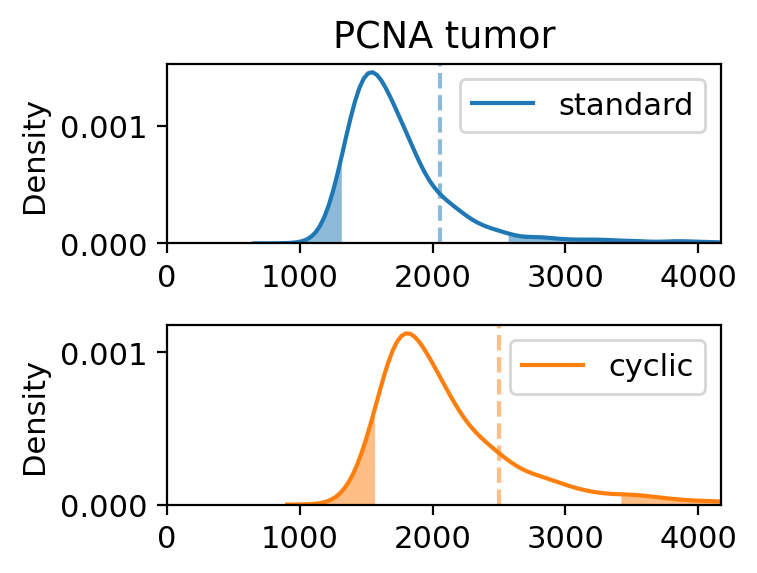

In [21]:
#histograms showing manual threshold and shading for 5th and 95th percentile
matplotlib.rcParams.update({'font.size': 11})
import warnings
warnings.filterwarnings('ignore')

for s_slide in sorted(df_t[df_t.experiment=='single'].slide.unique()):
    ls_marker = df_t[df_t.slide==s_slide].marker.tolist()
    ls_maker_loc = [df_rois.columns[df_rois.columns.str.contains(item + '_' )][0] for item in ls_marker]
    df_single = df_rois.loc[df_rois.index.str.contains(s_slide),ls_marker_loc]
    s_tissue = df_t[df_t.slide==s_slide].experimenttype[0]
    s_cyclic = df_t[(df_t.experimenttype=='tumor') & (df_t.experiment=='cyclic')].slide[0]
    df_cyclic = df_rois.loc[df_rois.index.str.contains(s_cyclic),ls_marker_loc]
    for idx, s_marker in enumerate(ls_marker_loc):
        se_single = df_single.loc[:,s_marker]
        se_cyclic = df_cyclic.loc[:,s_marker]
        if se_single.isna().sum()==0:
            fig,ax = plt.subplots(2,1,figsize=(4,3),dpi=200)
            i_max = np.quantile(se_single.append(se_cyclic),0.99)
            #single 
            a_sing = sns.kdeplot(se_single,ax=ax[0],label='standard').get_lines()[0].get_data()
            i_high = np.quantile(se_single,.95)
            i_low = np.quantile(se_single,.05)
            ax[0].fill_between(x=a_sing[0], y1=a_sing[1], y2=0,where=a_sing[0] > i_high,facecolor='C0',alpha=0.5)
            ax[0].fill_between(x=a_sing[0], y1=a_sing[1], y2=0,where=a_sing[0] < i_low,facecolor='C0',alpha=0.5)
            #thresh
            i_manual = df_t[(df_t.experimenttype==s_tissue) & (df_t.experiment=='single')& (df_t.marker==s_marker.split('_')[0])].minimum[0]
            if i_manual > i_max:
                i_manual=i_max - 100
            ax[0].axvline(i_manual, c=f'C0',alpha=0.5,ls='--')
            #cyclic 
            a_cyc = sns.kdeplot(se_cyclic,ax=ax[1],color='C1',label='cyclic').get_lines()[0].get_data()
            i_high = np.quantile(se_cyclic,.95)
            i_low = np.quantile(se_cyclic,.05)
            ax[1].fill_between(x=a_cyc[0], y1=a_cyc[1], y2=0,where=a_cyc[0] > i_high,facecolor='C1',alpha=0.5)
            ax[1].fill_between(x=a_cyc[0], y1=a_cyc[1], y2=0,where=a_cyc[0] < i_low,facecolor='C1',alpha=0.5)
            #thresh
            i_manual = df_t[(df_t.experimenttype==s_tissue) & (df_t.experiment=='cyclic')& (df_t.marker==s_marker.split('_')[0])].minimum[0]
            if i_manual > i_max:
                i_manual=i_max - 100
            ax[1].axvline(i_manual, c=f'C1',alpha=0.5,ls='--')
            ax[0].set_xlabel('')
            ax[1].set_xlabel('')
            ax[0].legend()
            ax[1].legend()
            ax[1].set_xlim(left=0,right=i_max)
            ax[0].set_xlim(left=0,right=i_max)
            ax[0].set_title(f"{s_marker.split('_')[0]} {s_tissue}")
            plt.tight_layout()
            fig.savefig(f'{codedir}/Figures/44290/SingvCyc_shaded_{s_tissue}_{s_marker}_kde.png')
            break
    break

# Dynamic range

Lin et al, elife 2018 [https://elifesciences.org/articles/31657] quantified dynamic range using the 5th and 95th percentile of pixel intensity. We compared this quantification to our manual determination of signal and background based on staining pattern.

In [22]:
#calculate 5th and 98th percentile to estimate dynamic range
df_result = pd.DataFrame()
for s_index in df_t.index:
    s_slide = df_t.loc[s_index,'slide']
    s_marker = df_t.loc[s_index,'marker']
    df_result.loc[s_index,'tissue'] = df_t.loc[s_index,'experimenttype']
    df_result.loc[s_index,'process'] = df_t.loc[s_index,'experiment']
    df_result.loc[s_index,'slide'] = s_slide
    df_result.loc[s_index,'marker'] = s_marker
    se_feat = df_rois.loc[df_rois.index.str.contains(s_slide),df_rois.columns.str.contains(f'{s_marker}_')]
    df_result.loc[s_index,'low05'] = se_feat.quantile(0.05)[0]
    df_result.loc[s_index,'high95'] = se_feat.quantile(0.98)[0]
df_result['dynamic_range'] = df_result.high95 - df_result.low05
df_result['estimated_SBR'] = (df_result.high95- df_result.low05)/df_result.low05


Text(0.5, 1.0, 'Dynamic Range of Markers in Cyclic IF')

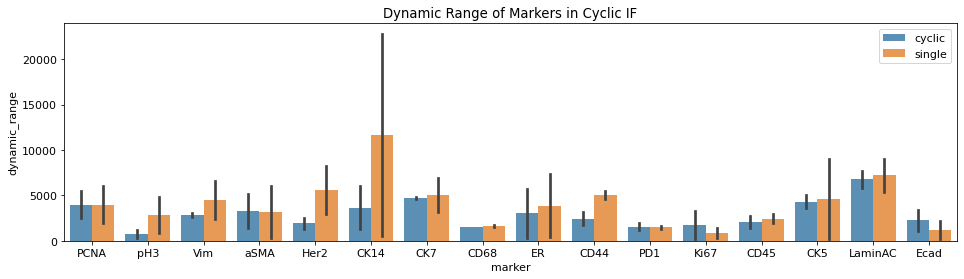

In [23]:
# plot dynamic range; defined as 5th percentile to 95th percentile 
df_plot = df_result[~df_result.marker.isin(['CK19','CD20','CD4','CD8'])]
fig,ax = plt.subplots(figsize=(16,4))
sns.barplot(x="marker", y="dynamic_range", hue="process", data=df_plot, ax=ax, alpha=0.8)
ax.legend()
ax.set_title('Dynamic Range of Markers in Cyclic IF')

Text(0.5, 1.0, 'Estimated Signal to Background Ratio (top 5%:bottom 5% of pixels) in Cyclic IF')

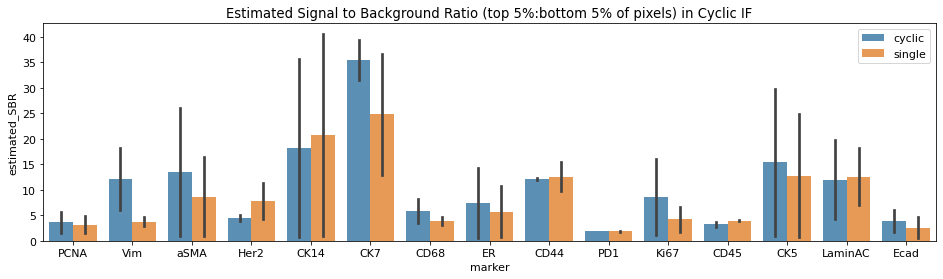

In [24]:
df_plot = df_result[~df_result.marker.isin(['CK19','CD20','CD4','CD8','pH3'])]
fig,ax = plt.subplots(figsize=(16,4))
sns.barplot(x="marker", y="estimated_SBR", hue="process", data=df_plot, ax=ax, alpha=0.8)
ax.legend()
ax.set_title('Estimated Signal to Background Ratio (top 5%:bottom 5% of pixels) in Cyclic IF')

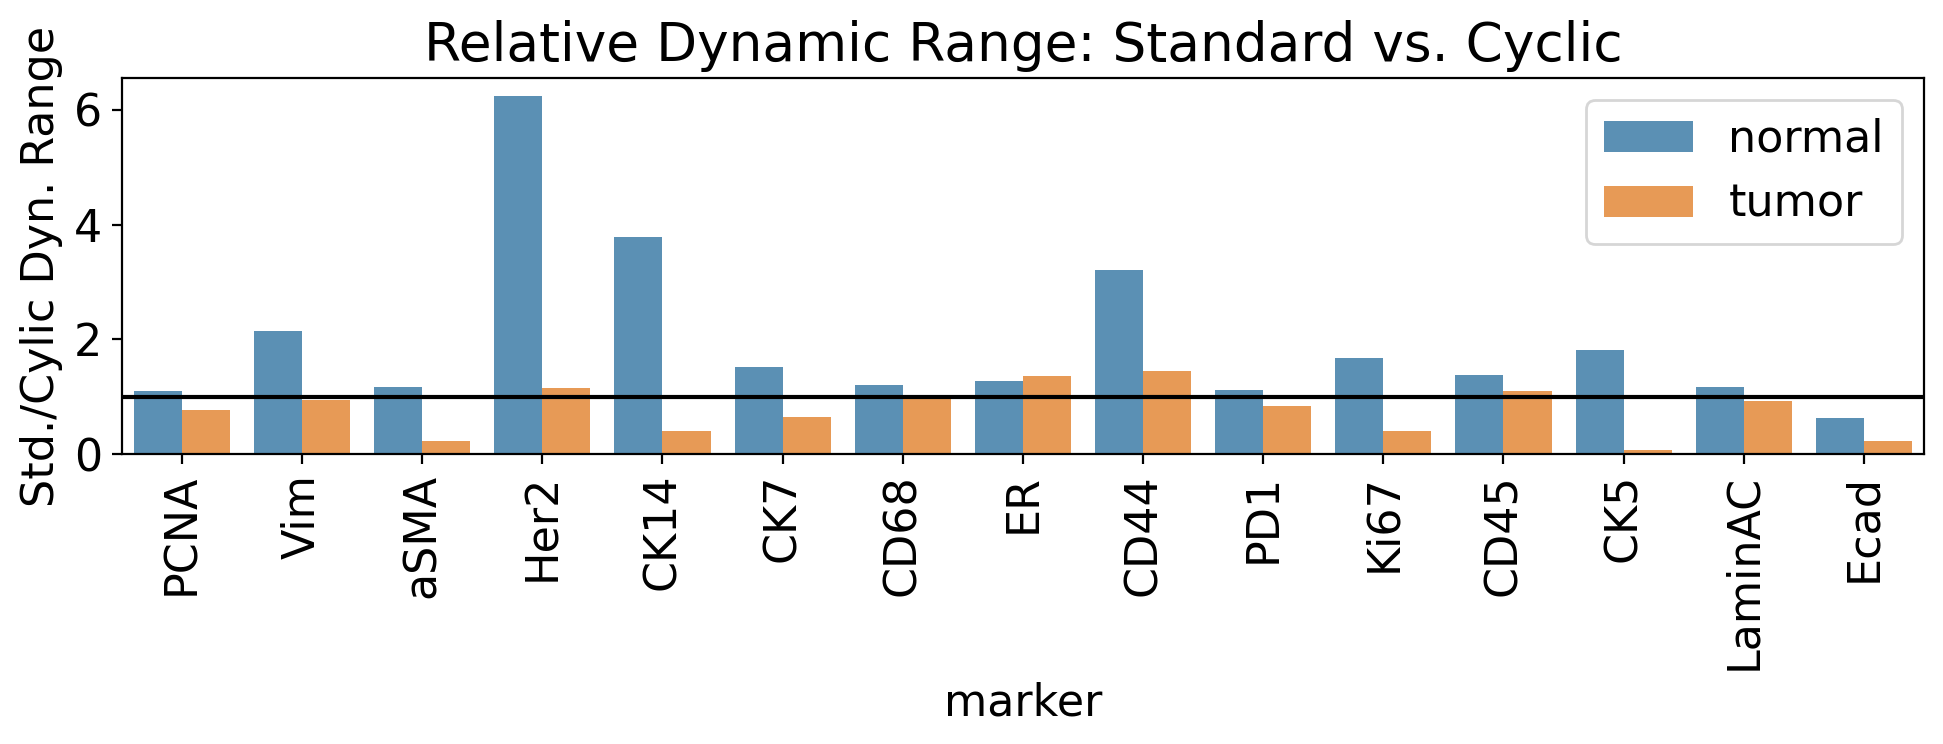

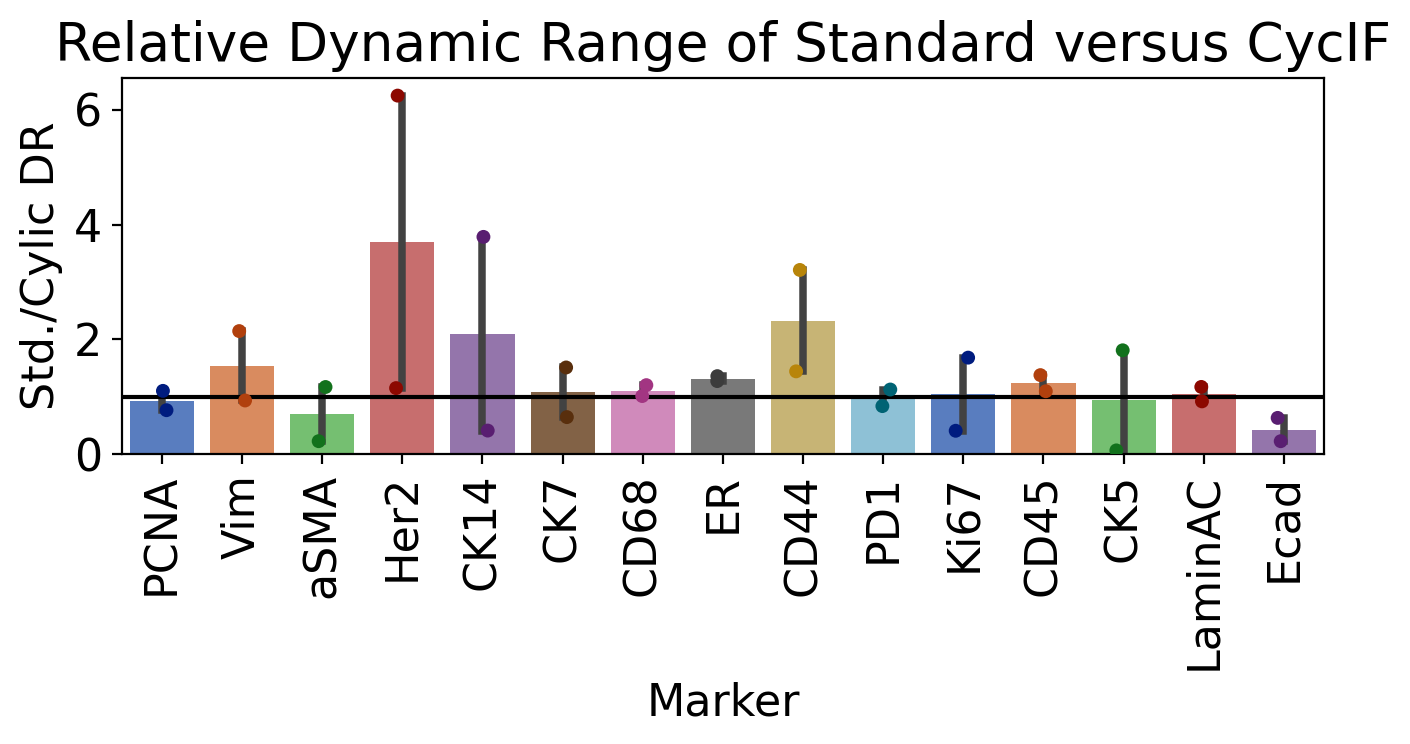

In [25]:
matplotlib.rcParams.update({'font.size': 16})
#calculate ratio of dynamic range
se_single = df_plot[df_plot.process=='single'].dynamic_range
se_single.index = df_plot[df_plot.process=='single'].tissue + '_' + df_plot[df_plot.process=='single'].marker

se_cyclic = df_plot[df_plot.process=='cyclic'].dynamic_range
se_cyclic.index = df_plot[df_plot.process=='cyclic'].tissue + '_' + df_plot[df_plot.process=='cyclic'].marker

df_ratio = pd.DataFrame(se_single/se_cyclic)
df_ratio['marker'] = [item.split('_')[1] for item in df_ratio.index]
df_ratio['process'] = [item.split('_')[0] for item in df_ratio.index]

#plot
fig,ax = plt.subplots(figsize=(10,4),dpi=200)
sns.barplot(x="marker", y="dynamic_range", hue="process", data=df_ratio, ax=ax, alpha=0.8)
ax.legend()
ax.set_ylabel('Std./Cylic Dyn. Range')
#ax.set_yscale('log')
ax.set_title('Relative Dynamic Range: Standard vs. Cyclic')
ax.axhline(1,color='black')
labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/44290/Dynamic_Range_Ratio_Single-Cyclic.png')

#barplot of mean
s_title = 'Relative Dynamic Range of Standard versus CycIF'
s_ylabel = 'Std./Cylic DR'
s_figname =f'{codedir}/Figures/44290/Dynamic_Range_mean_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_ratio, x='marker', y='dynamic_range', palette = 'muted', ci='sd')
sns.stripplot(data=df_ratio, x='marker', y='dynamic_range', palette = 'dark')
ax.set_ylabel(s_ylabel)
#ax.set_ylim(0,3.3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)

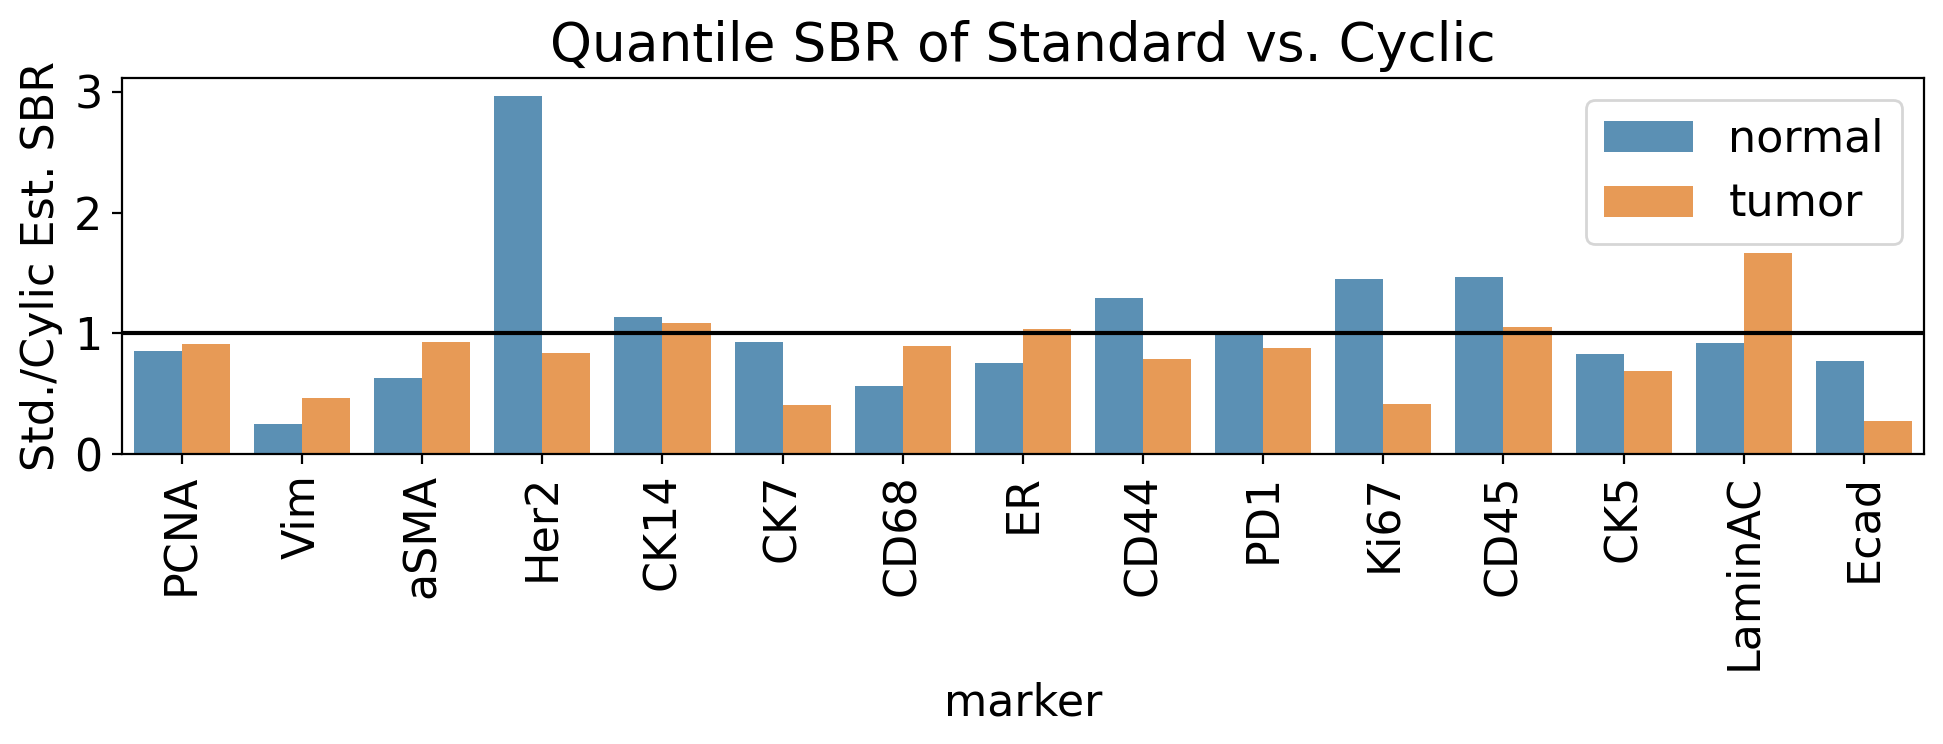

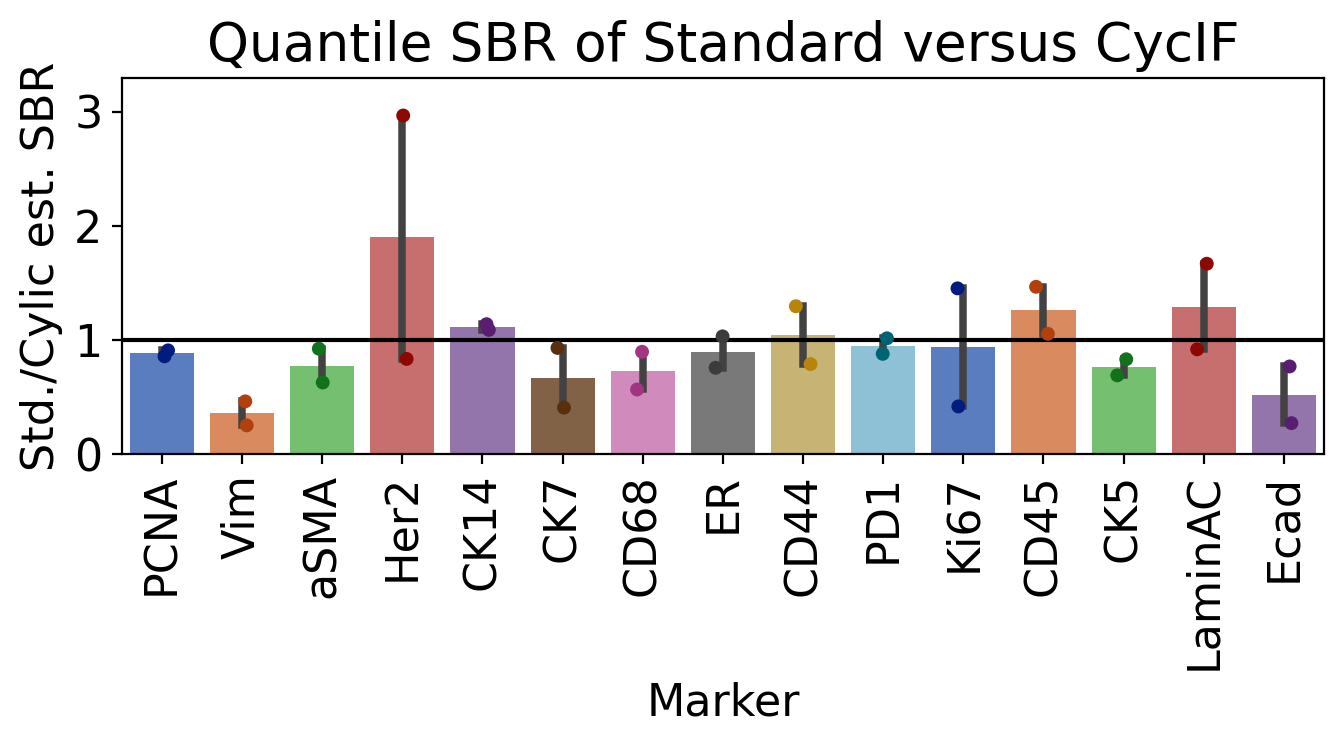

In [27]:

#calculate ratio of estimated SBR
se_single = df_plot[df_plot.process=='single'].estimated_SBR
se_single.index = df_plot[df_plot.process=='single'].tissue + '_' + df_plot[df_plot.process=='single'].marker

se_cyclic = df_plot[df_plot.process=='cyclic'].estimated_SBR
se_cyclic.index = df_plot[df_plot.process=='cyclic'].tissue + '_' + df_plot[df_plot.process=='cyclic'].marker

df_ratio = pd.DataFrame(se_single/se_cyclic)
df_ratio['marker'] = [item.split('_')[1] for item in df_ratio.index]
df_ratio['process'] = [item.split('_')[0] for item in df_ratio.index]
#plot
fig,ax = plt.subplots(figsize=(10,4),dpi=200)
sns.barplot(x="marker", y="estimated_SBR", hue="process", data=df_ratio, ax=ax, alpha=0.8)
ax.legend()
ax.set_ylabel('Std./Cylic Est. SBR')
#ax.set_yscale('log')
ax.set_title('Quantile SBR of Standard vs. Cyclic')
ax.axhline(1,color='black')
labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/44290/Estimate_SBR_Ratio_Single-Cyclic.png')

#barplot of mean
s_title = 'Quantile SBR of Standard versus CycIF'
s_ylabel = 'Std./Cylic est. SBR'
s_figname =f'{codedir}/Figures/44290/Estimate_meanSBR_Ratio_Single-Cyclic.png'
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
sns.barplot(data=df_ratio, x='marker', y='estimated_SBR', palette = 'muted', ci='sd')
sns.stripplot(data=df_ratio, x='marker', y='estimated_SBR', palette = 'dark')
ax.set_ylabel(s_ylabel)
ax.set_ylim(0,3.3)
ax.set_xlabel("Marker")
ax.axhline(1,color='black')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title(s_title)

plt.tight_layout()
fig.savefig(s_figname)